<h1 align=center> Работу выполнила студентка группы ПИ19-3 Александрова Дарья
<h2 align=center> Тема: "Машинное обучение в задачах классификации текстов"
<h3  align=center> Исходные данные: https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

Для дальнейшей работы импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import emoji

import re
import time

from PIL import Image
from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
import spacy

from collections import defaultdict,Counter

from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier
from sklearn.pipeline import Pipeline 
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split, learning_curve,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix, f1_score

from imblearn.over_sampling import RandomOverSampler

from xgboost import XGBClassifier

palette=sns.color_palette('magma')
sns.set(palette=palette)
pd.options.mode.chained_assignment = None
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner']) # для лемматизации

<h1> Цель работы

Coronavirus tweets NLP – общедоступный датасет, содержащий информацию о почти 50000 пользовательских сообщениях в социальной сети “Twitter” на тему коронавируса. Цель классификации – понять, каким является твит – негативным или же позитивным. Рассмотрим датасет подробнее и ознакомимся с его количественными характеристиками. 

<h1> Изучение исходных данных и их предварительный анализ

Считаем данные:

In [2]:
train_data=pd.read_csv('D://downloads/Corona_NLP_train.csv',encoding='latin-1')
test_data=pd.read_csv('D://downloads/Corona_NLP_test.csv',encoding='latin-1')

train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Проведем описательный анализ:

In [4]:
train_data.shape, test_data.shape

((41157, 6), (3798, 6))

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3798 entries, 0 to 3797
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       3798 non-null   int64 
 1   ScreenName     3798 non-null   int64 
 2   Location       2964 non-null   object
 3   TweetAt        3798 non-null   object
 4   OriginalTweet  3798 non-null   object
 5   Sentiment      3798 non-null   object
dtypes: int64(2), object(4)
memory usage: 178.2+ KB


Заметим, что в выборке присутствуют пустые значения в Location, однако в дальнейшем этот лейбл нас не будет интересовать, так как локация твита никак не влияет на ее содержание, и нет нужды в отдельной обработке.

In [8]:
train_data['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

Как мы видим, уникальных эмоциональных окрасов в выборке 5. В дальнейшем сузим этот набор.

Посмотрим на статистику стран с наибольшим количеством твитов:

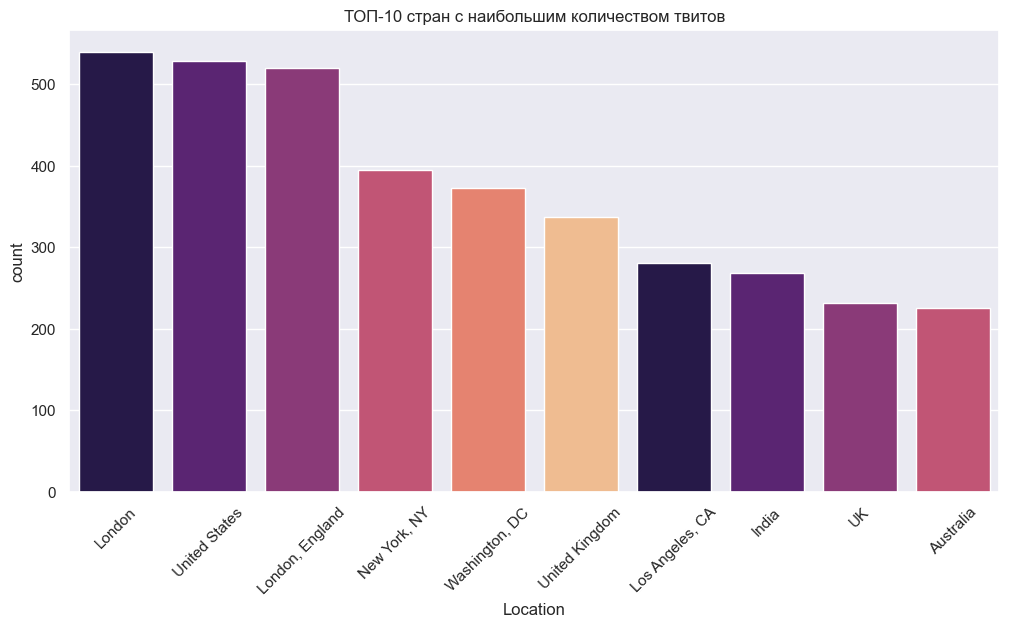

In [9]:
plt.figure(figsize=(12,6))
plt.title('ТОП-10 стран с наибольшим количеством твитов')
countries =sns.countplot(x='Location', data=train_data, order=train_data['Location'].value_counts().index[:10], palette=palette)
countries.set_xticklabels(countries.get_xticklabels(), rotation=45)
plt.show() 

Посмотрим на распределение целевой переменной. Как мы видим, преобладают позитивные сообщения, однако не с сильно большим отрывом.

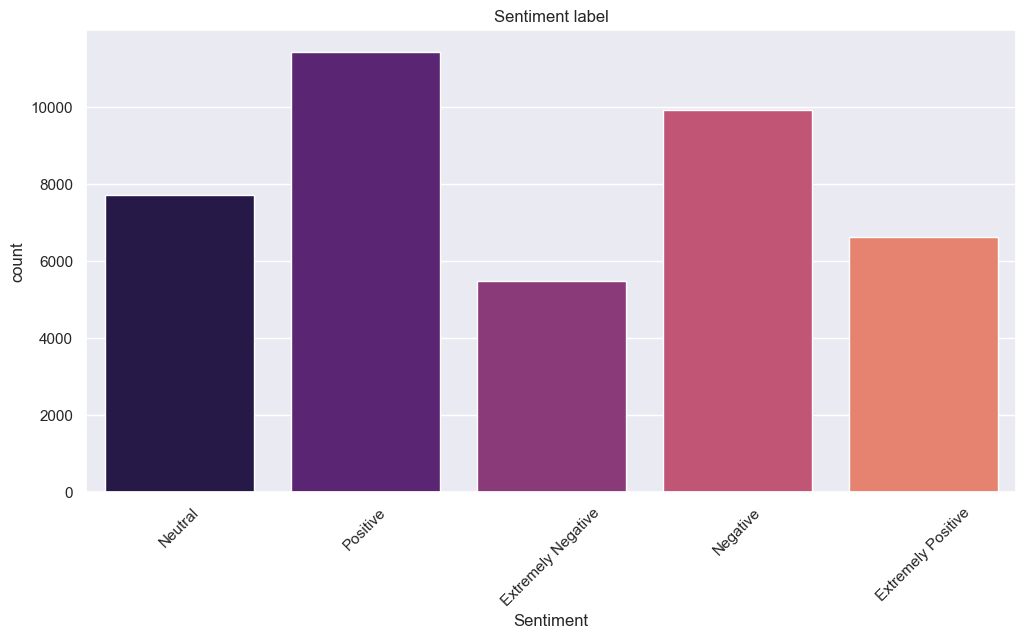

In [10]:
plt.figure(figsize=(12,6))
plt.title('Sentiment label')
countries =sns.countplot(x='Sentiment', data=train_data,  palette=palette)
countries.set_xticklabels(countries.get_xticklabels(), rotation=45)
plt.show() 

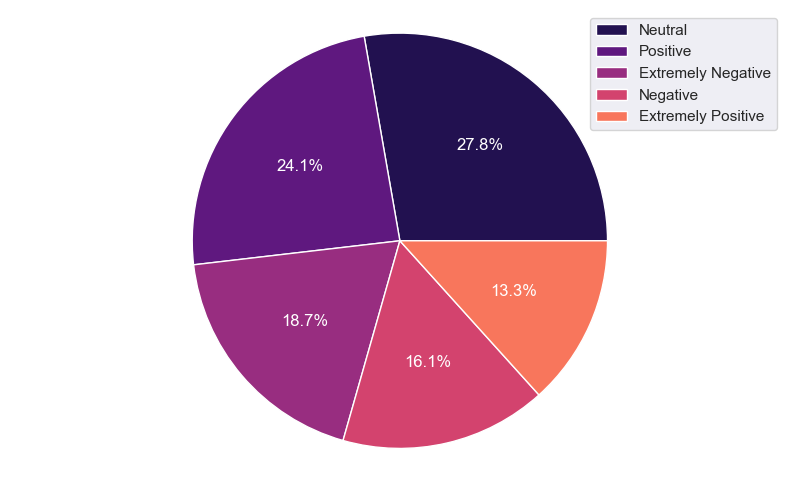

In [11]:
plt.figure(figsize=(10,6))
plt.pie(train_data['Sentiment'].value_counts(), labels=train_data['Sentiment'].unique(), autopct='%.1f%%', textprops={'color':"w"})
plt.legend(loc='upper right')
plt.axis('equal')
plt.show()

Посмотрим на количество символов в каждом из классов. (Заметим, что было выполнено сужение до 3 классов). 
У позитивных и негативных - наибольшее количество сообщений в размере около 250 символов. У нейтрального класса распределение без ярко выраженных выбросов.

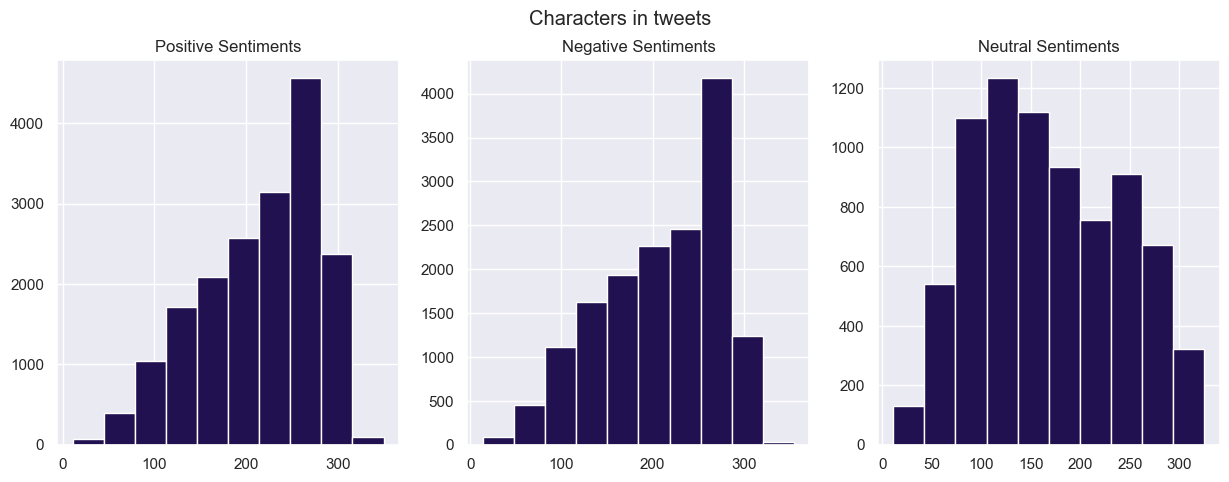

In [12]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train_data[(train_data['Sentiment']=="Positive")|(train_data['Sentiment']=="Extremely Positive")]['OriginalTweet'].str.len()
ax1.hist(tweet_len)
ax1.set_title('Positive Sentiments')

tweet_len=train_data[(train_data['Sentiment']=="Negative")|(train_data['Sentiment']=="Extremely Negative")]['OriginalTweet'].str.len()
ax2.hist(tweet_len)
ax2.set_title('Negative Sentiments')

tweet_len=train_data[train_data['Sentiment']=="Neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_len)
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

Посмотрим, на допустимые диапазоны. Получается, очищать выборку не придется, так как данное количество символов входит в допустимое.

In [14]:
first_q = np.quantile(train_data['OriginalTweet'].str.len(),q=0.25)
third_q = np.quantile(train_data['OriginalTweet'].str.len(),q=0.75)
first_q-1.5*(third_q-first_q),third_q+1.5*(third_q-first_q)

(-11.0, 421.0)

Также посмотрим на распределение количества слов:

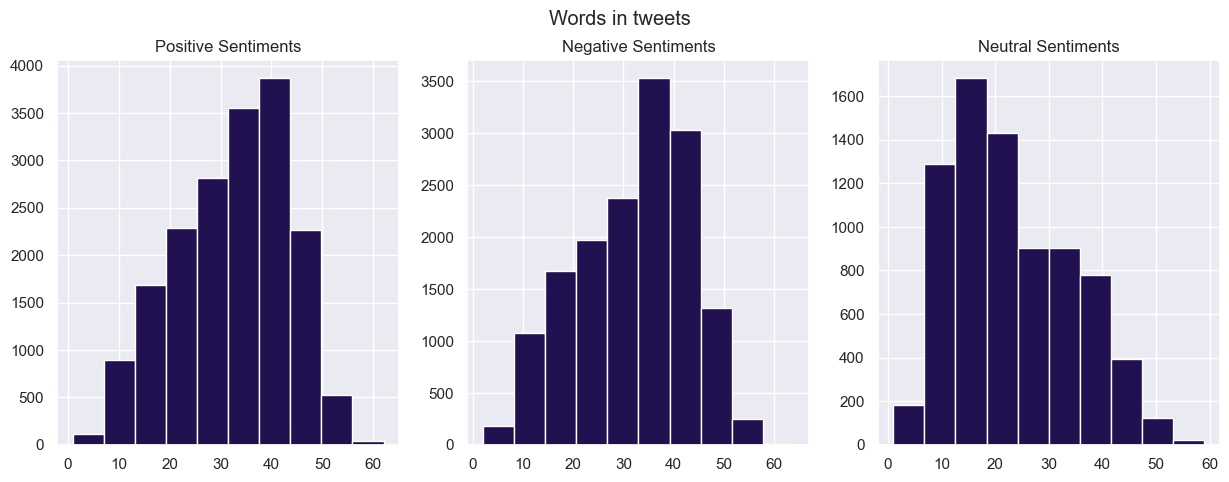

In [15]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len_w=train_data[(train_data['Sentiment']=="Positive")|(train_data['Sentiment']=="Extremely Positive")]['OriginalTweet'].str.split().str.len()
ax1.hist(tweet_len_w)
ax1.set_title('Positive Sentiments')

tweet_len_w=train_data[(train_data['Sentiment']=="Negative")|(train_data['Sentiment']=="Extremely Negative")]['OriginalTweet'].str.split().str.len()
ax2.hist(tweet_len_w)
ax2.set_title('Negative Sentiments')

tweet_len_w=train_data[train_data['Sentiment']=="Neutral"]['OriginalTweet'].str.split().str.len()
ax3.hist(tweet_len_w)
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in tweets')
plt.show()

Повторим аналогичную процедуру по поиску выбросов на основе медианных значений. Обработки не потребуется.

In [18]:
first_q = np.quantile(train_data['OriginalTweet'].str.split().str.len(),q=0.25)
third_q = np.quantile(train_data['OriginalTweet'].str.split().str.len(),q=0.75)
first_q-1.5*(third_q-first_q),third_q+1.5*(third_q-first_q)

(-7.5, 68.5)

Изучим wordCloud наших данных:

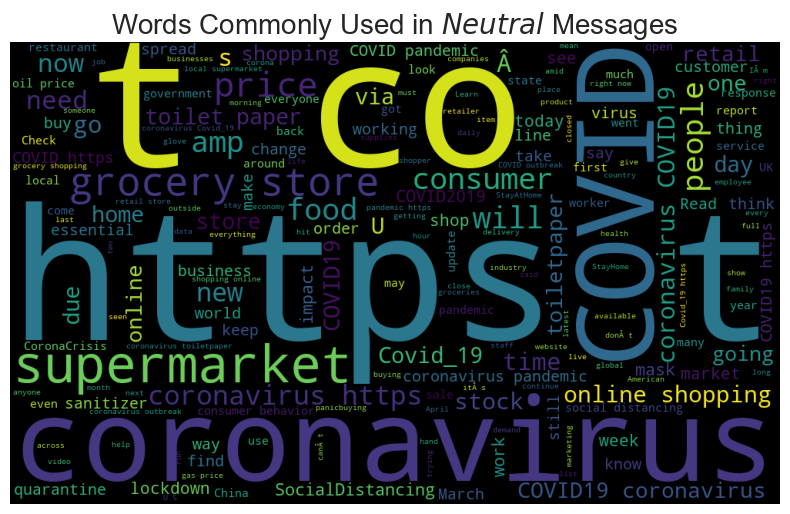

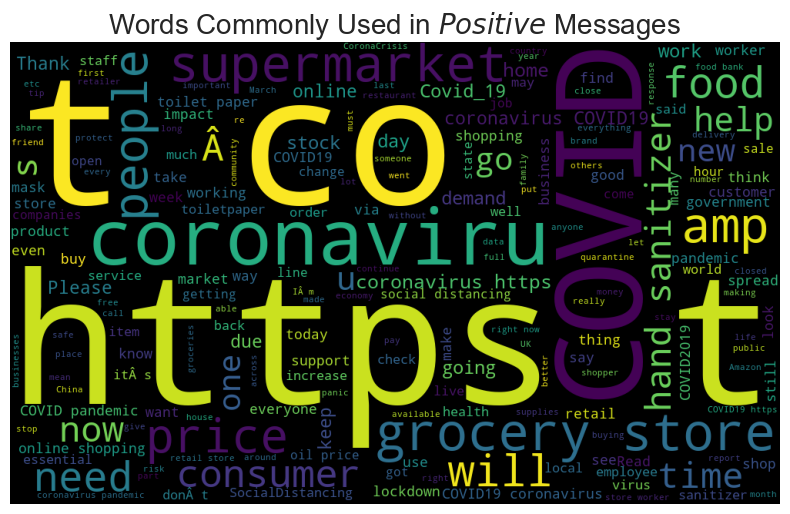

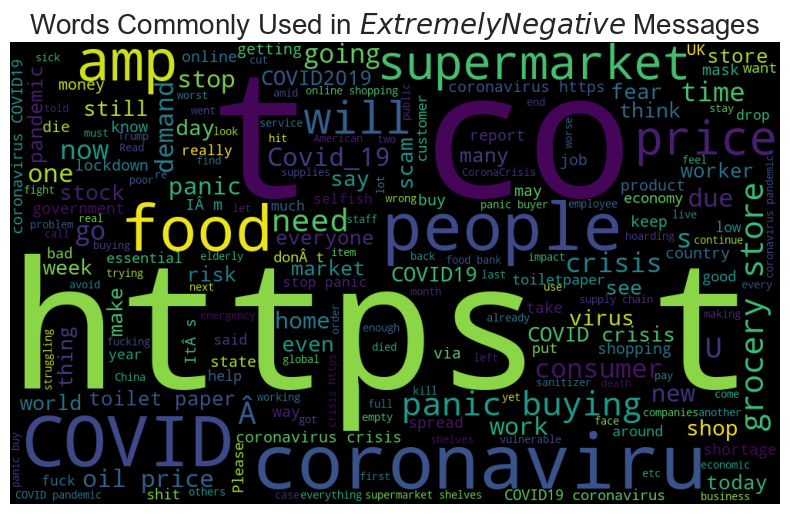

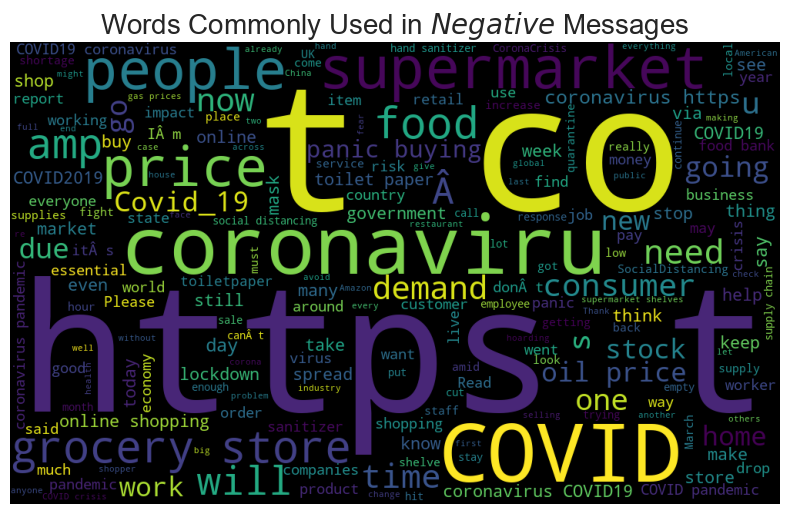

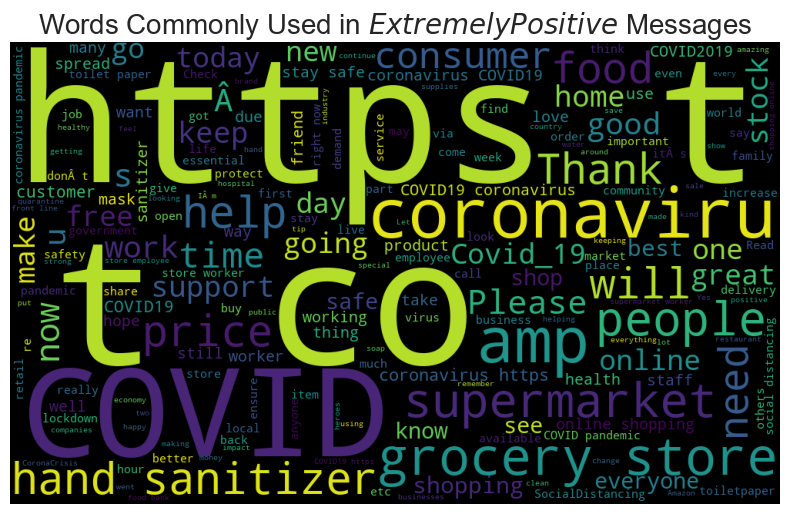

In [27]:
for label in train_data['Sentiment'].unique().tolist():
    text = train_data.query('Sentiment == @label')['OriginalTweet'].str.cat(sep=' ')
    plt.figure(figsize=(10, 6))
    wc = WordCloud(width=1000, height=600)
    wc.generate_from_text(text)
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"Words Commonly Used in ${label}$ Messages", size=20)
    plt.show()

Так как интересующие нас колонки имеют тип String, то матрица корреляций не включает их отношения.
Username, screenName, TweetAt, Location явно не являются значимыми признаками для нашей задачи.
Только интересует сам текст твита и его эмоциональная характеристика. Это и будут наш X и Y.

In [28]:
train_data.corr()

,UserName,ScreenName
UserName,1.0,1.0
ScreenName,1.0,1.0


In [3]:
#Заинтересованы только в OriginalTweet и Sentiment
train_df= train_data[['OriginalTweet','Sentiment']]
test_df= test_data[['OriginalTweet','Sentiment']]

train_df.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Посмотрим, как размечены наши данные:

In [42]:
#Coronavirus Australia: Woolworths выделяет пожилым людям и инвалидам специальные часы для покупок на фоне вспышки COVID-19
print("==============================================Исходный текст:==================================================================\n")
print(train_data["OriginalTweet"].head()[2])
print("=========================================================Оценка:===============================================================\n")
print(train_data["Sentiment"].head()[2])
print("==============================================Исходный текст:==================================================================\n")
print(train_data["OriginalTweet"].head()[3])
print("=========================================================Оценка:===============================================================\n")
print(train_data["Sentiment"].head()[3])

==============================================Исходный текст:==================================================================

Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
=========================================================Оценка:===============================================================

Positive
==============================================Исходный текст:==================================================================






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinementotal #ConfinementGeneral https://t.co/zrlG0Z520j
=========================================================Оценка:===============================================================

Positive


<h1> Преобразования исходных данных

Преобразуем категориальную переменную в числовую (при этом отметим, что в данной задаче классификации нам не важно,
в какой степени твит будет позитивным или негативным).

In [4]:
target_mapping={'Extremely Negative':0, 'Negative':0, 'Neutral':1,
                'Positive':2, 'Extremely Positive':2}

train_df['SentimentMapped']=train_df['Sentiment'].map(lambda x:target_mapping[x])
test_df['SentimentMapped']=test_df['Sentiment'].map(lambda x:target_mapping[x])

train_df.head()

,OriginalTweet,Sentiment,SentimentMapped
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1
1,advice Talk to your neighbours family to excha...,Positive,2
2,Coronavirus Australia: Woolworths to give elde...,Positive,2
3,My food stock is not the only one which is emp...,Positive,2
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


Проведем предварительную очистку данных от слов, не имеющих определенной семантики. Для этого будем использовать регулярные выражения. Также преобразуем в нижний регистр для понижения количества уникальных слов в мешке (таким образом, оптимизируем вычислительные алгоритмы в дальнейшем):

In [5]:
def cleaner(tweet):
    # удаление ссылок
    tweet = "".join(re.sub("(\w+:\/\/\S+)"," ", tweet))
    
    # удаление хештегов
    tweet = "".join(re.sub("(#[A-Za-z0-9_]+)"," ", tweet))
    
    # удаление упоминания юзера
    tweet = "".join(re.sub("(@[A-Za-z0-9_]+)"," ", tweet))
    
    # удаление ненужных символов
    tweet = "".join(re.sub("([^0-9A-Za-z \t'])"," ", tweet))
    
    # удаление многочисленных пробелов
    tweet = " ".join(tweet.split())
    
    # удаление эмоджи
    tweet = "".join(c for c in tweet if c not in emoji.UNICODE_EMOJI) 
    
    # удаление пробелов в начале и в конце
    tweet = tweet.strip()
    
    #перевод в нижний регистр 
    tweet = tweet.lower()
    
    return tweet

In [7]:
%%time

train_df['CleanedTweet'] = train_df['OriginalTweet'].apply(lambda x: cleaner(x))
test_df['CleanedTweet'] = test_df['OriginalTweet'].apply(lambda x: cleaner(x))

Wall time: 8.95 s


Посмотрим на результат очистки:

In [13]:
for i in train_df[train_df['CleanedTweet']!=train_df['OriginalTweet']][['OriginalTweet','CleanedTweet']][:5].values:
    print("До очистки: ",i[0])
    print("После очистки: ",i[1])
    print('\n===============================================================================================================================')

До очистки:  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8
После очистки:  and and

До очистки:  advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order
После очистки:  advice talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist gp set up online shopping accounts if poss adequate supplies of regular meds but not over order

До очистки:  Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P
После очистки:  coronavirus australia woolworths to give elderly disabled dedicated shopping hours amid covid 19 outbreak






#COVID19france #COVID_19 #COVID19 #coronavirus #confinement #Confinemen

Отбросим строки, в которых оказалось меньше 5 слов после предыдущих преобразований:

In [14]:
train_df.shape, test_df.shape

((41157, 4), (3798, 4))

In [9]:
%%time

train_df = train_df[train_df['CleanedTweet'].apply(lambda x: len(x.split()) > 5)]
test_df = test_df[test_df['CleanedTweet'].apply(lambda x: len(x.split()) > 5)]

Wall time: 131 ms


Изменения в размере выборок оказались весьма значительны:

In [10]:
train_df.shape, test_df.shape

((40312, 4), (3755, 4))

Посмотрим на распределение целевой переменной после преобразований (преобладание позитивного и негативного классов):

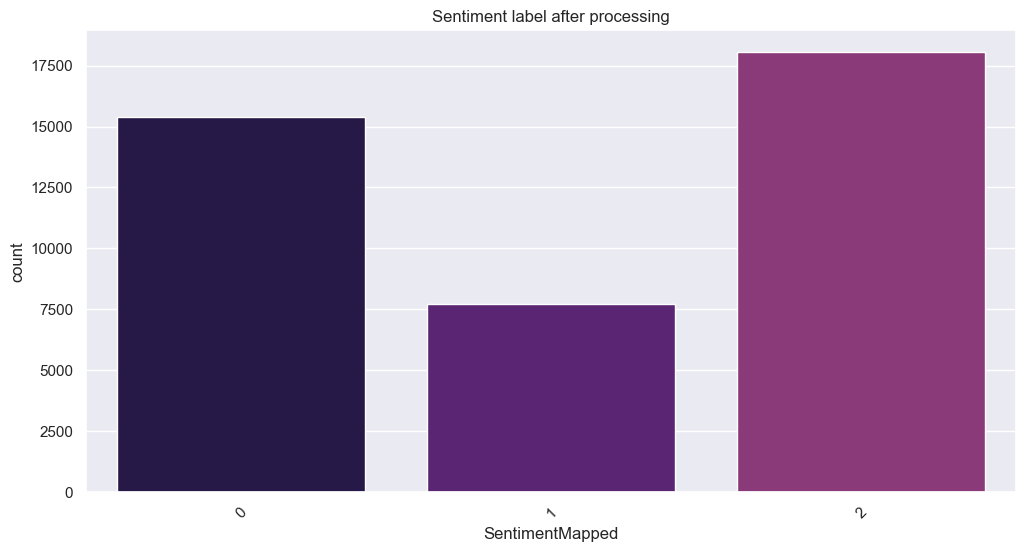

In [7]:
plt.figure(figsize=(12,6))
plt.title('Sentiment label after processing')
countries =sns.countplot(x='SentimentMapped', data=train_df,  palette=palette)
countries.set_xticklabels(countries.get_xticklabels(), rotation=45)
plt.show() 

Повторно проведем процедуру поиска аномалий в каждом твите:

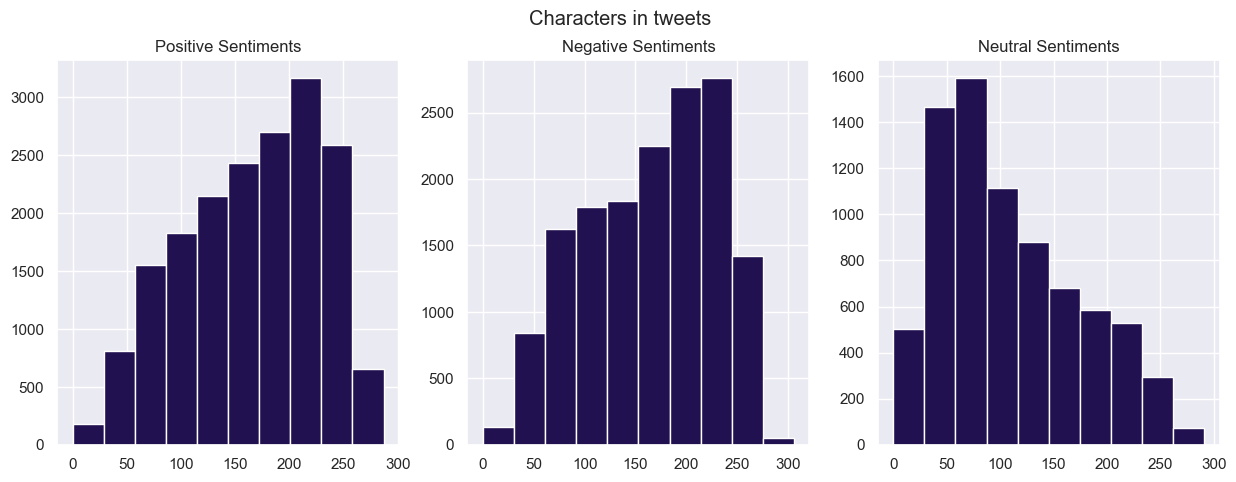

In [8]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train_df[train_df['SentimentMapped']==2]['CleanedTweet'].str.len()
ax1.hist(tweet_len)
ax1.set_title('Positive Sentiments')

tweet_len=train_df[train_df['SentimentMapped']==0]['CleanedTweet'].str.len()
ax2.hist(tweet_len)
ax2.set_title('Negative Sentiments')

tweet_len=train_df[train_df['SentimentMapped']==1]['CleanedTweet'].str.len()
ax3.hist(tweet_len)
ax3.set_title('Neutral Sentiments')

fig.suptitle('Characters in tweets')
plt.show()

In [9]:
#аномалий не выявлено
first_q = np.quantile(train_df['CleanedTweet'].str.len(),q=0.25)
third_q = np.quantile(train_df['CleanedTweet'].str.len(),q=0.75)
first_q-1.5*(third_q-first_q),third_q+1.5*(third_q-first_q)

(-73.0, 383.0)

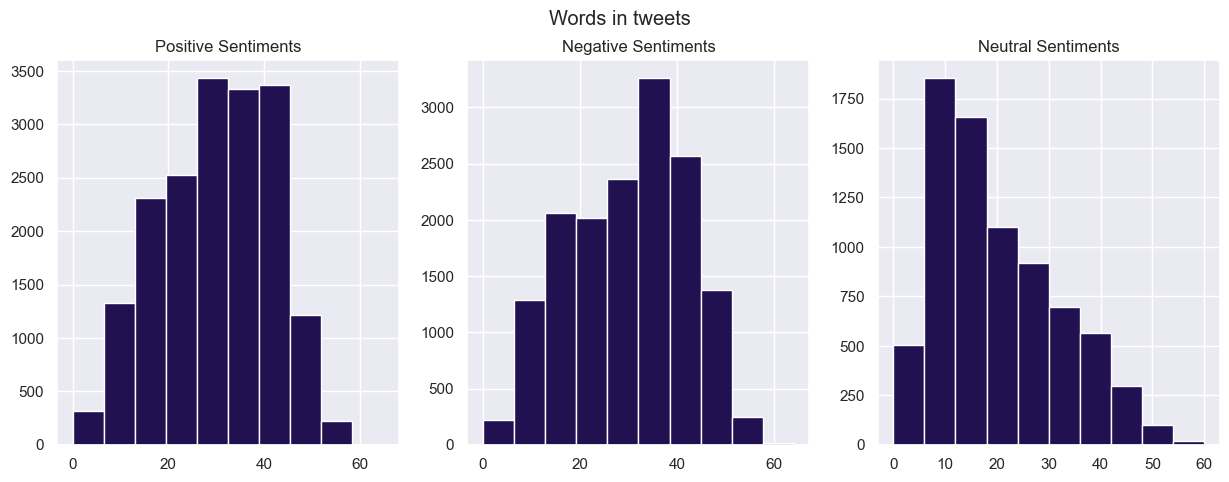

In [10]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

tweet_len=train_df[train_df['SentimentMapped']==2]['CleanedTweet'].str.split().str.len()
ax1.hist(tweet_len)
ax1.set_title('Positive Sentiments')

tweet_len=train_df[train_df['SentimentMapped']==0]['CleanedTweet'].str.split().str.len()
ax2.hist(tweet_len)
ax2.set_title('Negative Sentiments')

tweet_len=train_df[train_df['SentimentMapped']==1]['CleanedTweet'].str.split().str.len()
ax3.hist(tweet_len)
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in tweets')
plt.show()

In [11]:
#аномалий не выявлено
first_q = np.quantile(train_df['CleanedTweet'].str.split().str.len(),q=0.25)
third_q = np.quantile(train_df['CleanedTweet'].str.split().str.len(),q=0.75)
first_q-1.5*(third_q-first_q),third_q+1.5*(third_q-first_q)

(-12.0, 68.0)

Посмотрим, почему стоит избавиться от стоп-слов. В самом деле, самые частовстречаемые слова - это стоп-слова, которые не несут никаких нагрузки (предлоги, союзы и т.д.).
Будем использовать методы NLTK для достижения этой цели.

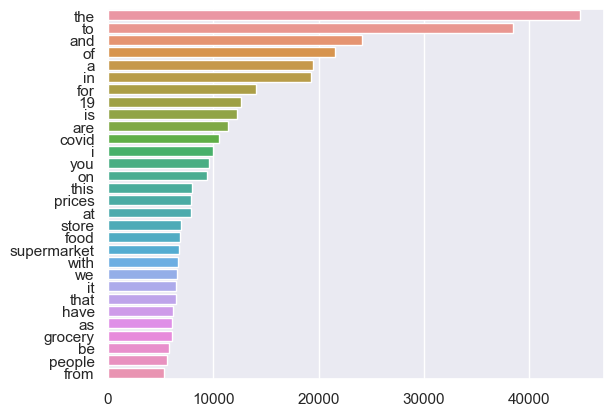

In [8]:
counter=Counter(" ".join(train_df['CleanedTweet']).split()).most_common(30)
x=[]
y=[]
for word,count in counter:
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.show() 

Выполним токенизацию текста и удалим стоп-слова (допустимо использование лемматизации и стемминга).
Обработка датасета заняла порядка 3.5 минут.

In [6]:
%%time

def tokenize(text,lemma=True,stem=False,keepStopWords=set(),lang='english'):
    #keepStopWord - слова, которые не стоит удалять (могут быть полезны)
    #lemma - использовать лемматизацию
    #stem - использовать стемминг
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    
    if lemma:
        tokens = word_tokenize(text)
        doc = nlp(" ".join(tokens)) 
        text = ' '.join([token.lemma_ for token in doc if token.pos_ in allowed_postags])
          
    if stem:
        stemmer = SnowballStemmer(lang)
        tokens = word_tokenize(text)
        text = ' '.join([stemmer.stem(item) for item in tokens])
    
    stopwords_list = set(stopwords.words(lang)) - keepStopWords
    words = word_tokenize(text)
    text = ' '.join([word for word in words if word not in stopwords_list])
    
    return text
    
keep_words = {'not', 'could', 'would'}

train_df['CleanedTweet'] = train_df['CleanedTweet'].apply(tokenize, keepStopWords=keep_words,stem=False,lemma=True)
test_df['CleanedTweet'] = test_df['CleanedTweet'].apply(tokenize, keepStopWords=keep_words,stem=False,lemma=True)


Wall time: 35.1 s


Повторим визуализацию. Теперь частовстречаемые слова наиболее явно отражают тематику задачи:

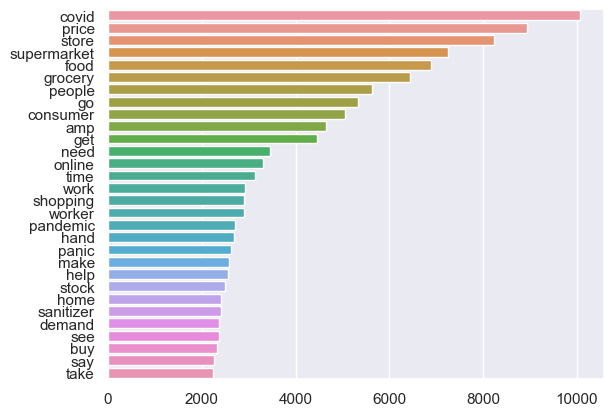

In [15]:
counter=Counter(" ".join(train_df['CleanedTweet']).split()).most_common(30)
x=[]
y=[]
for word,count in counter:
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)
plt.show() 

Посмотрим на wordCloud:

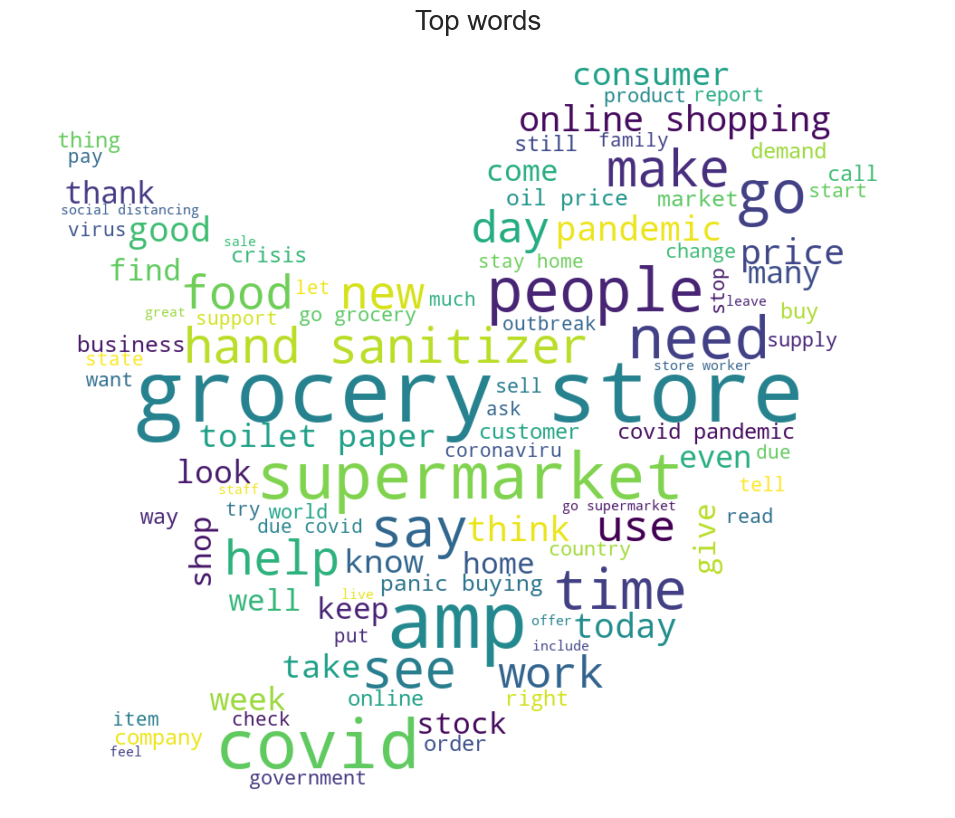

In [21]:
mask = np.array(Image.open('D://downloads/twitter-logo.png'))

wordcloud = WordCloud(background_color='white',
                      max_words=100,
                      mask=mask)

wordcloud.generate(' '.join(text for text in train_df['CleanedTweet']))

plt.figure(figsize=(20,10))
plt.title("Top words", fontdict={'size': 20})
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  
plt.show()

# Обучение без учителя. Кластеризация 

В качестве алгоритма воспользуемся кластеризацией K-средних, так как алгоритм имеет линейную сложность O(n) и очень быстр.
Наша цель - дать модели найти самой зависимости при заданном количестве кластеров (3), при этом не сообщая ей ничего о целевой переменной. 

In [13]:
#предварительная векторизация исходных данных
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
vectors = vectorizer.fit_transform(train_df['CleanedTweet'])

Можно заметить, что в данной задаче кластеризация не дает полезных знаний, так как в каждом сообщении важен контекст, а не только сами слова. Если бы речь шла о классификации животных по цвету, весу и прочих характеристиках, то такое разбиение могло бы помочь. Именно поэтому можно приступать к обучению моделей с учителем. 

10 наиболее встречаемых слов в кластере 0:  [('supermarket', 6941), ('food', 5622), ('people', 3362), ('covid', 3038), ('go', 2807), ('online', 2600), ('get', 2470), ('shopping', 2278), ('panic', 2271), ('need', 1983)]
10 наиболее встречаемых слов в кластере 1:  [('price', 8589), ('consumer', 4832), ('covid', 4772), ('amp', 2247), ('sanitizer', 2103), ('hand', 2087), ('pandemic', 1693), ('oil', 1522), ('time', 1340), ('make', 1256)]
10 наиболее встречаемых слов в кластере 2:  [('store', 6912), ('grocery', 5799), ('go', 1589), ('worker', 1346), ('people', 1091), ('get', 1004), ('work', 963), ('covid', 954), ('amp', 646), ('employee', 639)]


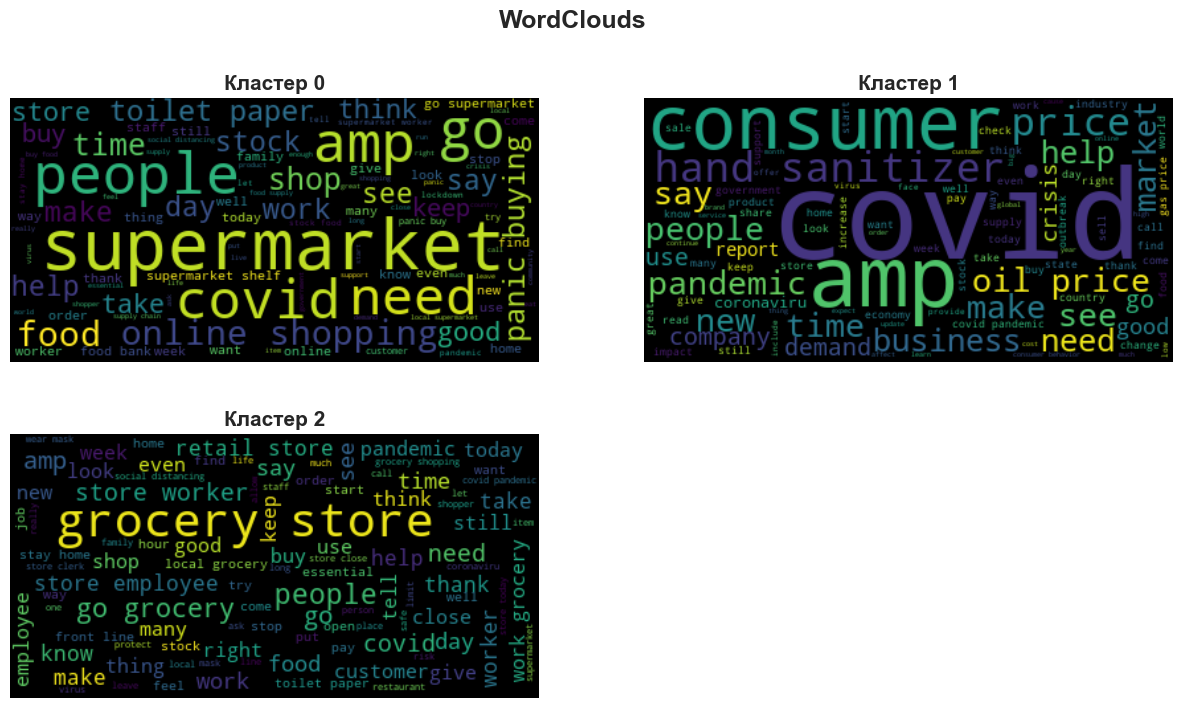

Wall time: 49.8 s
Parser   : 368 ms


In [14]:
%%time

n_clusters = 3
n_words = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=0, max_iter=10)
kmeans.fit(vectors)

labels = {k:[] for k in range (n_clusters)}
for i, label in enumerate(kmeans.labels_):
    labels[label].append(i)

#соединяем все сообщения в кластеры по label
text_clusters = {k:"" for k in range (n_clusters)}
for k in range(n_clusters):
    text_clusters[k] = ' '.join(train_df['CleanedTweet'].iloc[labels[k]])
    
# часто встречаемые в заданном кластере
for k, text in text_clusters.items():
    print(f"{n_words} наиболее встречаемых слов в кластере {k}:  {Counter(text.split()).most_common(n_words)}")

# WordClouds
fig, axs = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle("WordClouds", fontweight='bold', fontsize=18)
for i in range(n_clusters):
    wordcloud = WordCloud(max_words=100).generate(text_clusters[i])
    axs[i//2][i%2].set_title(f"Кластер {i}", fontdict = {'fontsize':15, 'fontweight':'bold'})
    axs[i//2][i%2].imshow(wordcloud, interpolation='bilinear')
    axs[i//2][i%2].axis("off")     
fig.delaxes(axs[1][1])
plt.show()

# Разделение на обучающую и тестовую выборки

Данные неоднородны. В дальнейшем можно будет использовать искуственное выравнивание датасета. Сейчас же остановимся на использовании параметра stratify.

In [15]:
train_df.groupby('SentimentMapped')['CleanedTweet'].count()

SentimentMapped
0    15253
1     7208
2    17851
Name: CleanedTweet, dtype: int64

Стоит отметить важную особенность исходных данных – автор изначально разбил их на тестовые и обучающие (в соотношении 9/91). Сперва не будем использовать метод train_test_split и посмотрим на работу алгоритмов на заранее «разделенных» выборках. В дальнейшем соединим исходные данные (тестовые и тренировочные) и сделаем случайное разбиение 80/20. Возможно, результат получится лучше, так как количество данных для обучения явно увеличится.

Методов разделения выборки существует большое количество – для временных рядов, случайный, последовательный. Остановимся на случайном методе разбиения выборки, так как у последовательного есть недостаток – упорядоченной структуре это только навредит, хоть алгоритм и прост. 

In [18]:
x_train = train_df['CleanedTweet'].values
y_train = train_df['SentimentMapped'].values

X_test = test_df['CleanedTweet'].values
y_test = test_df['SentimentMapped'].values

Воспользуемся CountVectorizer. В дальнейшем можно будет поэксперементировать и найти более подходящий способ векторизации для наилучшений модели.

In [48]:
clf = CountVectorizer(ngram_range=(1, 1))
X_train_cv =  clf.fit_transform(x_train)
X_test_cv = clf.transform(X_test)

# Обучение с учителем. Построение моделей и их сравнение

Будем рассматривать несколько различных моделей для классификации и выберем наиболее перспективную.

Список: 

1. MultinomialNB
2. Logistic Regression
3. DecisionTree
4. SGD Classifier
5. RandomForest
6. XGBoost
7. LinearSVC
8. KNN

In [49]:
%%time

nb_clf = MultinomialNB()
nb_clf.fit(X_train_cv, y_train)
nb_pred = nb_clf.predict(X_test_cv)

print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test,nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.71      0.78      0.75      1630
     Neutral       0.51      0.17      0.25       587
    Positive       0.67      0.77      0.71      1538

    accuracy                           0.68      3755
   macro avg       0.63      0.57      0.57      3755
weighted avg       0.66      0.68      0.65      3755

Wall time: 29 ms


Результат не впечатляет, так как классы не выровнены. Точность 0.68 лишь обманчива, на деле алгоритм не обучился на нейтральном классе - об этом говорит полнота, равна 0.17.

In [50]:
%%time

logr_clf = LogisticRegression(max_iter=1000)
logr_clf.fit(X_train_cv, y_train)
logr_pred = logr_clf.predict(X_test_cv)

print('\tClassification Report for LogisticRegression:\n\n',classification_report(y_test,logr_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for LogisticRegression:

               precision    recall  f1-score   support

    Negative       0.83      0.80      0.82      1630
     Neutral       0.67      0.72      0.69       587
    Positive       0.81      0.82      0.81      1538

    accuracy                           0.79      3755
   macro avg       0.77      0.78      0.77      3755
weighted avg       0.80      0.79      0.80      3755

Wall time: 8.81 s


In [40]:
len(y_train[y_train==2]),len(y_train[y_train==0]),len(y_train[y_train==1])

(17851, 15253, 7208)

In [41]:
len(y_test[y_test==2]),len(y_test[y_test==0]),len(y_test[y_test==1])

(1538, 1630, 587)

В этот раз алгоритм смог неплохо обучится на нейтральном классе. В целом, везде точность и полнота на хорошем уровне. Разумеется, нейтральный класс будет отставать, так как данные не сбалансированы.
Качество модели хорошее.

In [51]:
%%time

dt_clf=DecisionTreeClassifier()
dt_clf.fit(X_train_cv, y_train)
dt_pred = dt_clf.predict(X_test_cv)

print('\tClassification Report for DecisionTreeClassifier:\n\n',classification_report(y_test,dt_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for DecisionTreeClassifier:

               precision    recall  f1-score   support

    Negative       0.69      0.66      0.67      1630
     Neutral       0.56      0.62      0.59       587
    Positive       0.65      0.66      0.66      1538

    accuracy                           0.65      3755
   macro avg       0.63      0.65      0.64      3755
weighted avg       0.66      0.65      0.65      3755

Wall time: 17.9 s


Время выполнения алгоритма – 18 секунд, что выше, чем у конкурентов.  Результаты оказались весьма сбалансированы для всех трех классов, поэтому метрика accuracy в данном случае является показательной.

In [53]:
%%time

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train_cv, y_train)
sgd_pred = sgd_clf.predict(X_test_cv)

print('\tClassification Report for SGDClassifier:\n\n',classification_report(y_test,sgd_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for SGDClassifier:

               precision    recall  f1-score   support

    Negative       0.83      0.83      0.83      1630
     Neutral       0.68      0.73      0.71       587
    Positive       0.83      0.81      0.82      1538

    accuracy                           0.81      3755
   macro avg       0.78      0.79      0.79      3755
weighted avg       0.81      0.81      0.81      3755

Wall time: 576 ms


Результат очень впечатляет. Качество модели на хорошем уровне даже при базовых параметрах (а этот метод очень чувствителен к изменениям). Полнота и точность нейтрального класса превышают 0.65. 

In [52]:
%%time

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_cv, y_train)
rf_pred = rf_clf.predict(X_test_cv)

print('\tClassification Report for RandomForestClassifier:\n\n',classification_report(y_test,rf_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for RandomForestClassifier:

               precision    recall  f1-score   support

    Negative       0.77      0.73      0.75      1630
     Neutral       0.58      0.62      0.60       587
    Positive       0.73      0.75      0.74      1538

    accuracy                           0.72      3755
   macro avg       0.69      0.70      0.70      3755
weighted avg       0.72      0.72      0.72      3755

Wall time: 1min 40s


Алгоритм обучался чуть более минуты – это уже значительная разница по сравнению с предыдущими. Результаты оказались неплохие по всем классам, но, опять же, бросается в глаза отличие в нейтральном классе

In [47]:
%%time

xg_clf = XGBClassifier(use_label_encoder=False,eval_metric="mlogloss")
xg_clf.fit(X_train_cv, y_train)
xg_pred = xg_clf.predict(X_test_cv)

print('\tClassification Report for XGBClassifier:\n\n',classification_report(y_test,xg_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for XGBClassifier:

               precision    recall  f1-score   support

    Negative       0.80      0.73      0.76      1630
     Neutral       0.59      0.65      0.62       587
    Positive       0.73      0.77      0.75      1538

    accuracy                           0.73      3755
   macro avg       0.71      0.72      0.71      3755
weighted avg       0.74      0.73      0.73      3755

Wall time: 40.6 s


Результат оказался неплохим, однако время обучения оказалось равным почти минуте.

In [58]:
%%time

svc_clf = SVC()
svc_clf.fit(X_train_cv, y_train)
svc_pred = svc_clf.predict(X_test_cv)

print('\tClassification Report for SVC(kernel=rbf):\n\n',classification_report(y_test,svc_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for SVC(kernel=linear):

               precision    recall  f1-score   support

    Negative       0.81      0.76      0.79      1630
     Neutral       0.63      0.67      0.65       587
    Positive       0.77      0.79      0.78      1538

    accuracy                           0.76      3755
   macro avg       0.73      0.74      0.74      3755
weighted avg       0.76      0.76      0.76      3755

Wall time: 12min 57s


In [57]:
%%time

lsvc_clf = LinearSVC(max_iter=100000)
lsvc_clf.fit(X_train_cv, y_train)
lsvc_pred = lsvc_clf.predict(X_test_cv)

print('\tClassification Report for LinearSVC:\n\n',classification_report(y_test,lsvc_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for LinearSVC:

               precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      1630
     Neutral       0.65      0.68      0.66       587
    Positive       0.79      0.80      0.79      1538

    accuracy                           0.78      3755
   macro avg       0.75      0.76      0.75      3755
weighted avg       0.78      0.78      0.78      3755

Wall time: 25.5 s


Метод опорных векторов (линейный) оказался значительно быстрее обычного метода опорных векторов, метрики качества показали неплохие результаты.

In [59]:
%%time

neigh_clf = KNeighborsClassifier()
neigh_clf.fit(X_train_cv, y_train)
neigh_pred = neigh_clf.predict(X_test_cv)

print('\tClassification Report for KNeighborsClassifier:\n\n',classification_report(y_test,neigh_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for KNeighborsClassifier:

               precision    recall  f1-score   support

    Negative       0.69      0.31      0.42      1630
     Neutral       0.20      0.90      0.33       587
    Positive       0.67      0.17      0.27      1538

    accuracy                           0.34      3755
   macro avg       0.52      0.46      0.34      3755
weighted avg       0.60      0.34      0.35      3755

Wall time: 5.03 s


Методу ближайших соседей понадобилось 5 секунд. Качество модели плохое, вероятно, это связано с тем, что метод сам по себе прост в реализации. Однако удивительным фактором является полнота нейтрального класса.

После проделанной работы необходимо выбрать наиболее перспективную модель. Назовем перспективной моделью ту, затраченное время которой будет минимально, а показатели качества стремится к единице. Можно заметить, что такой моделью будет являться SGDClassifier – стохастический градиентный спуск.

# Улучшение перспективной модели

<h2> Векторизация

Попробуем посмотреть на роль векторизации. Сравним CountVectorzer и TfidfVectorizer, также работая с количеством элементов в последовательности.

In [74]:
# Pipelines
pip_uni = Pipeline([ ('countUni', CountVectorizer(ngram_range=(1, 1))), ('clf', SGDClassifier()) ])
pip_bi = Pipeline([ ('countBi', CountVectorizer(ngram_range=(2, 2))), ('clf', SGDClassifier()) ])
pip_tri = Pipeline([ ('countTri', CountVectorizer(ngram_range=(3, 3))), ('clf', SGDClassifier()) ])
pip = Pipeline([ ('countUniBi', CountVectorizer(ngram_range=(1, 2))), ('clf', SGDClassifier()) ])

# Lists
names = ["Unigrams","Bigrams","Trigrams","Uni+Bigrams"]
pipelines = [pip_uni, pip_bi, pip_tri, pip]
res = []

# Results
for i, p in enumerate(pipelines) :
    val_score = cross_val_score(p, train_df['CleanedTweet'], train_df["SentimentMapped"]).mean()
    res.append({'n_grams':names[i],'Score':val_score})

results = pd.DataFrame(res).sort_values(by='Score', ascending=False)
results.style.background_gradient("Blues")

,n_grams,Score
0,Unigrams,0.808370
3,Uni+Bigrams,0.786119
1,Bigrams,0.576975
2,Trigrams,0.499901


In [75]:
# Pipelines
pip_uni = Pipeline([ ('tfidfUni', TfidfVectorizer(ngram_range=(1, 1))), ('clf', SGDClassifier()) ])
pip_bi = Pipeline([ ('tfidfBi', TfidfVectorizer(ngram_range=(2, 2))), ('clf', SGDClassifier()) ])
pip_tri = Pipeline([ ('tfidfTri', TfidfVectorizer(ngram_range=(3, 3))), ('clf', SGDClassifier()) ])
pip = Pipeline([ ('tfidfUniBi', TfidfVectorizer(ngram_range=(1, 2))), ('clf', SGDClassifier()) ])

# Lists
names = ["Unigrams","Bigrams","Trigrams","Uni+Bigrams"]
pipelines = [pip_uni, pip_bi, pip_tri, pip]
res = []

# Results

for i, p in enumerate(pipelines) :
    val_score = cross_val_score(p, train_df['CleanedTweet'], train_df["SentimentMapped"]).mean()
    res.append({'n_grams':names[i],'Score':val_score})

results = pd.DataFrame(res).sort_values(by='Score', ascending=False)
results.style.background_gradient("Blues")

,n_grams,Score
0,Unigrams,0.769275
3,Uni+Bigrams,0.728940
1,Bigrams,0.587418
2,Trigrams,0.507020


Вывод: использование CountVectorizer с униграммами является наиболее предпочтительным вариантом.

<h2> Разбиение выборки

Попробуем использовать случайное разбиение выборки. Для этого соединим тестовую и обучающую выборки, созданные автором датасета.

In [8]:
concat_df = pd.concat([train_df,test_df])
concat_df

,OriginalTweet,Sentiment,SentimentMapped,CleanedTweet
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,and and
1,advice Talk to your neighbours family to excha...,Positive,2,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,2,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,2,my food stock is not the only one which is emp...
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,me ready to go at supermarket during the outbr...
...,...,...,...,...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive,2,meanwhile in a supermarket in israel people da...
3794,Did you panic buy a lot of non-perishable item...,Negative,0,did you panic buy a lot of non perishable item...
3795,Asst Prof of Economics @cconces was on @NBCPhi...,Neutral,1,asst prof of economics was on talking about he...
3796,Gov need to do somethings instead of biar je r...,Extremely Negative,0,gov need to do somethings instead of biar je r...


Теперь разделим в пропорциях 75% и 25%: (ранее было 90% и 10%):

In [11]:
X = concat_df['CleanedTweet'].values
y = concat_df['SentimentMapped'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,  stratify=y, random_state=43)

clf = CountVectorizer(ngram_range=(1, 1))
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [90]:
%%time

sgd_clf = SGDClassifier(l1_ratio=0.5,penalty='l1')
sgd_clf.fit(X_train_cv, y_train)
sgd_pred = sgd_clf.predict(X_test_cv)

print('\tClassification Report for SGDClassifier:\n\n',classification_report(y_test,sgd_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for SGDClassifier:

               precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      4221
     Neutral       0.70      0.80      0.75      1949
    Positive       0.86      0.82      0.84      4847

    accuracy                           0.82     11017
   macro avg       0.80      0.82      0.81     11017
weighted avg       0.82      0.82      0.82     11017

Wall time: 1.03 s


Вывод: изменение количества данных помогло обучиться модели лучше. Видимо, это связано с изначальным переобучением. 

<h2> Первоначальная обработка данных

Попробуем изменить обработку первоначальных данных. Уберем использование лемматизации/стемминга и посмотрим на результат. В самом деле, показатели оказались намного выше. Вероятно, использование приведения слова к какой-либо словоформе влияет на обучение модели (проблема недообучения)

In [12]:
%%time

sgd_clf = SGDClassifier(l1_ratio=0.5,penalty='l1')
sgd_clf.fit(X_train_cv, y_train)
sgd_pred = sgd_clf.predict(X_test_cv)

print('\tClassification Report for SGDClassifier:\n\n',classification_report(y_test,sgd_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for SGDClassifier:

               precision    recall  f1-score   support

    Negative       0.86      0.82      0.84      4221
     Neutral       0.73      0.85      0.79      1949
    Positive       0.88      0.86      0.87      4847

    accuracy                           0.84     11017
   macro avg       0.83      0.84      0.83     11017
weighted avg       0.85      0.84      0.84     11017

Wall time: 1.47 s


А что, если выполнять сначала токенизацию, а потом очистку от ненужных символов?

In [11]:
%%time

sgd_clf = SGDClassifier(l1_ratio=0.5,penalty='l1')
sgd_clf.fit(X_train_cv, y_train)
sgd_pred = sgd_clf.predict(X_test_cv)

print('\tClassification Report for SGDClassifier:\n\n',classification_report(y_test,sgd_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for SGDClassifier:

               precision    recall  f1-score   support

    Negative       0.88      0.85      0.86      4258
     Neutral       0.80      0.87      0.83      2083
    Positive       0.89      0.88      0.88      4898

    accuracy                           0.87     11239
   macro avg       0.85      0.87      0.86     11239
weighted avg       0.87      0.87      0.87     11239

Wall time: 3.35 s


В самом деле, так показатели намного лучше.

<h2> Поиск оптимальных параметров

Ранее были подобраны параметры для модели "на глаз". Попробуем провести GridSearch, для того чтобы найти наиболее оптимальную комбинацию параметров модели. 

In [12]:
param_grid = {
        'alpha': [0.00001,0.0001,0.01,0.1],
        'penalty' : ['l1','l2','elasticnet'],
        "l1_ratio": [0.1,0.4,0.5,0.7,1],
       'learning_rate': ['optimal', 'constant', 'invscaling'],
   }

sgd = SGDClassifier()

grid = GridSearchCV(sgd, param_grid,scoring = 'accuracy', return_train_score=True,verbose=2)
grid.fit(X_train_cv, y_train)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   4.1s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   4.0s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   4.3s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   4.5s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   4.0s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.9s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   1.0s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.9s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.8s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   1.1s
[CV] END alpha=1e-05, l1_ratio=0.1, l

D:\apps\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "D:\apps\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\apps\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "D:\apps\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "D:\apps\Anaconda\lib\site-packages\sklearn\linear_

0.8675407113461894
{'alpha': 0.0001, 'l1_ratio': 0.7, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}
SGDClassifier(l1_ratio=0.7, penalty='elasticnet')


In [13]:
%%time

sgd_clf = SGDClassifier(l1_ratio=0.7,penalty='elasticnet')
sgd_clf.fit(X_train_cv, y_train)
sgd_pred = sgd_clf.predict(X_test_cv)

print('\tClassification Report for SGDClassifier:\n\n',classification_report(y_test,sgd_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for SGDClassifier:

               precision    recall  f1-score   support

    Negative       0.90      0.85      0.87      4258
     Neutral       0.80      0.88      0.84      2083
    Positive       0.89      0.89      0.89      4898

    accuracy                           0.87     11239
   macro avg       0.86      0.87      0.87     11239
weighted avg       0.88      0.87      0.87     11239

Wall time: 1.18 s


В самом деле, была найдена модель с показателями выше.

<h2> Переход к бинарной классификации

Напоследок попробуем перейти к задаче бинарной классификации. Но можно ли это будет сделать на наших данных? Задача классификации эмоционального окраса очень непростая, особенно если в выборке присутствуют нейтральные сообщения – это можно было заметить по результатам работы любой представленной модели. Именно из-за этого класса сложно делать какие-либо предсказания даже человеку. Интересуют ли нас в таком случае эти сообщения? Почему бы не попробовать остановиться только на «позитивных» и «негативных» твитах, ведь цель курсовой работы – это определить, является ли сообщение негативным или позитивным. Такое разделение может помочь для дальнейшего анализа внутри социальной сети, например, в сообщениях с негативным окрасом есть вероятность нахождения запрещенных платформой действий. Несут ли какой-то смысл нейтральные сообщения в таком случае? Конечно, нет. Попробуем поработать с такой выборкой, оставив только 2 класса.

In [9]:
concat_df_2 = concat_df.drop(concat_df[concat_df.Sentiment == 'Neutral'].index)
concat_df_2.loc[concat_df_2["SentimentMapped"] == 2, "SentimentMapped"] = 1
concat_df_2

,OriginalTweet,Sentiment,SentimentMapped,CleanedTweet
1,advice Talk to your neighbours family to excha...,Positive,1,advice talk to your neighbours family to excha...
2,Coronavirus Australia: Woolworths to give elde...,Positive,1,coronavirus australia woolworths to give elder...
3,My food stock is not the only one which is emp...,Positive,1,my food stock is not the only one which is emp...
6,Cashier at grocery store was sharing his insig...,Positive,1,cashier at grocery store was sharing his insig...
8,Due to COVID-19 our retail store and classroom...,Positive,1,due to covid 19 our retail store and classroom...
...,...,...,...,...
3791,"With Gov Hogan's announcement that all bars, r...",Extremely Negative,0,with gov hogan's announcement that all bars re...
3792,"@RicePolitics @MDCounties Craig, will you call...",Negative,0,craig will you call on the general assembly to...
3793,Meanwhile In A Supermarket in Israel -- People...,Positive,1,meanwhile in a supermarket in israel people da...
3796,Gov need to do somethings instead of biar je r...,Extremely Negative,0,gov need to do somethings instead of biar je r...


In [10]:
X_2 = concat_df_2['CleanedTweet'].values
y_2 = concat_df_2['SentimentMapped'].values

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2,  stratify=y_2, random_state=43)

clf = CountVectorizer(ngram_range=(1, 1))
X_train_cv_2 =  clf.fit_transform(X_train_2)
X_test_cv_2 = clf.transform(X_test_2)

In [25]:
%%time

sgd_clf = SGDClassifier(l1_ratio=0.7,penalty='elasticnet')
sgd_clf.fit(X_train_cv_2, y_train_2)
sgd_pred = sgd_clf.predict(X_test_cv_2)

print('\tClassification Report for SGDClassifier:\n\n',classification_report(y_test_2,sgd_pred, target_names=['Negative','Positive']))

	Classification Report for SGDClassifier:

               precision    recall  f1-score   support

    Negative       0.90      0.88      0.89      4126
    Positive       0.90      0.91      0.91      4763

    accuracy                           0.90      8889
   macro avg       0.90      0.90      0.90      8889
weighted avg       0.90      0.90      0.90      8889

Wall time: 343 ms


Вывод: переход к бинарной классификации показал впечатляющие результаты. В данном случае метрика accuracy действительно представляет правдоподобную ситуацию, так как классы выровнены. Полнота и точность около 90% менее чем за 1 секунду – разве это не отличная модель?

Повторное улучшение и поиск оптимальных параметров для модели с бинарной классификацией:

In [28]:
param_grid = {
        'alpha': [0.00001,0.0001,0.01,0.1],
        'penalty' : ['l1','l2','elasticnet'],
        "l1_ratio": [0.1,0.4,0.5,0.7,1],
       'learning_rate': ['optimal', 'constant', 'invscaling'],
   }

sgd = SGDClassifier()

grid = GridSearchCV(sgd, param_grid,scoring = 'accuracy', return_train_score=True,verbose=2)
grid.fit(X_train_cv_2, y_train_2)


print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   1.0s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   0.8s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   0.9s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   1.0s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l1; total time=   0.9s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.2s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.2s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.2s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.2s
[CV] END alpha=1e-05, l1_ratio=0.1, learning_rate=optimal, penalty=l2; total time=   0.2s
[CV] END alpha=1e-05, l1_ratio=0.1, l

D:\apps\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
600 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "D:\apps\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\apps\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "D:\apps\Anaconda\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "D:\apps\Anaconda\lib\site-packages\sklearn\linear_

0.8951473485653034
{'alpha': 0.0001, 'l1_ratio': 0.5, 'learning_rate': 'optimal', 'penalty': 'elasticnet'}
SGDClassifier(l1_ratio=0.5, penalty='elasticnet')


In [29]:
%%time

sgd_clf = SGDClassifier(l1_ratio=0.5,penalty='elasticnet')
sgd_clf.fit(X_train_cv_2, y_train_2)
sgd_pred = sgd_clf.predict(X_test_cv_2)

print('\tClassification Report for SGDClassifier:\n\n',classification_report(y_test_2,sgd_pred, target_names=['Negative','Positive']))

	Classification Report for SGDClassifier:

               precision    recall  f1-score   support

    Negative       0.89      0.90      0.90      4126
    Positive       0.91      0.90      0.91      4763

    accuracy                           0.90      8889
   macro avg       0.90      0.90      0.90      8889
weighted avg       0.90      0.90      0.90      8889

Wall time: 486 ms


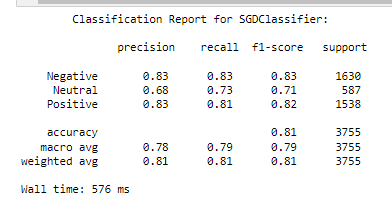

Можно заметить, что поиск оптимальных параметров дал модель с лучшим качеством.

Матрица ошибок:

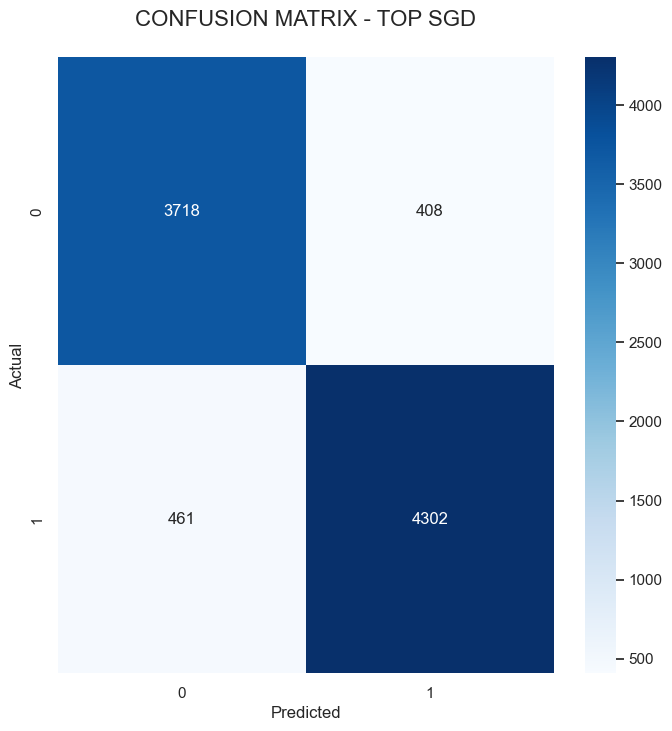

In [30]:
conf_mat = confusion_matrix(y_test_2,sgd_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - TOP SGD\n", size=16);
plt.show()

Одним из способов оценить модель в целом, не привязываясь к конкретному порогу, является ROC AUC кривая, которая представляет из себя линию от (0,0) до (1,1) в координатах True Positive Rate (TPR) и False Positive Rate (FPR):

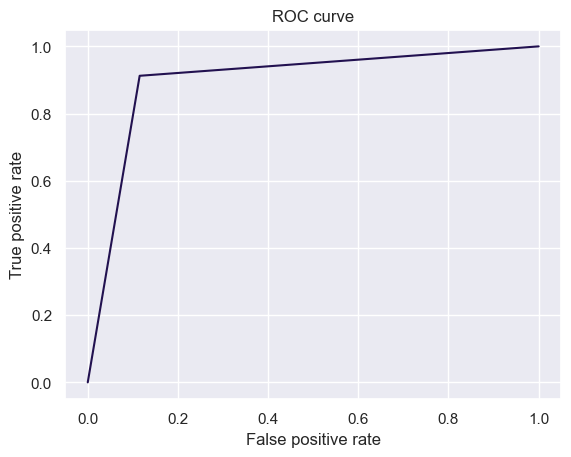

AUC of the predictions: 0.8986632650350816


In [26]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_2,sgd_pred)
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()
print("AUC of the predictions: {0}".format(metrics.auc(fpr, tpr)))

Качество модели на очень хорошем уровне, так как показатель приблизительно равен 0.9. Напоследок посмотрим на график зависимости точности от полноты:

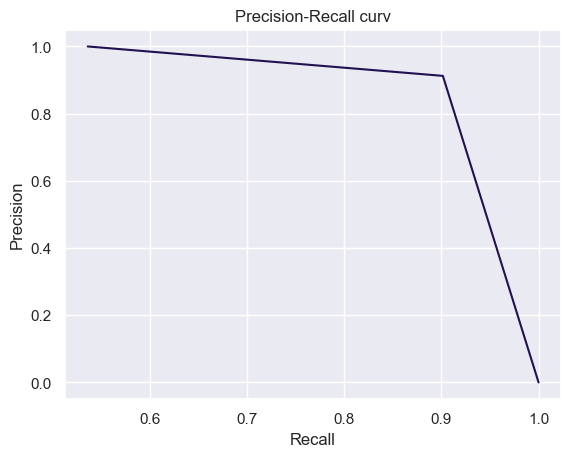

AUC of the predictions: 0.9304173867855201


In [27]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test_2, sgd_pred)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.show()
print("AUC of the predictions: {0}".format(metrics.auc(recall,precision)))

Вывод: значение 0.93 очень близко к 1, а это, опять же, подтверждает тот факт, что качество модели очень достойное.

<h1> Заключение 

В рамках работы были продемонстрированы навыки построения моделей машинного обучения в задачах классификации текстов, используя инструментальные средства библиотек языка программирования Python. 
Было рассмотрено 8 различных моделей для определения эмоционального окраса текста. Поиск наиболее перспективной опирался на следующие критерии: минимизация затраченного времени и максимизация метрик качества – такой моделью оказался классификатор с методом стохастического градиентного спуска. Она показала неплохие результаты менее, чем за секунду: полнота и точность всех трех классов была в среднем 0.7. Разумеется, огромную роль при классификации текстов играет первоначальная обработка данных, так как сообщение – это текстовая единица, а не числовая. Для того, чтобы алгоритмы смогли правильно работать с целевой переменной были необходимы переход от категориальной переменной к числу, а также предварительная очистка от токенов, не имеющих определенной семантики, и последующая векторизация. 
Для улучшения перспективной модели было рассмотрено несколько итераций, которые действительно привели к хорошему результату. Разбиение выборки в другом соотношении помогло решить проблему переобучения, а изменение обработки первоначальных данных – проблему недообучения. Также необходимо упомянуть мощный инструмент GridSearchCV, который помог найти наилучшую комбинацию параметров для конечной модели, так как стохастический градиентный спуск очень чувствителен к гиперпараметрам. Под конец был производен переход к бинарной классификации, так как нейтральные сообщения не несут какой-либо последующей полезной информации для дальнейшего анализа. Результат был впечатляющий – модель показала очень хорошие результаты классификации.
Таким образом, исследовав исходные данные для последующей качественной обработки и найдя наилучшую модель под них, был получен прирост в точности предсказывания результатов с 78% до 90%, а в полноте – с 79% до 90%. 

В дальнейшем для улучшения показателей можно будет попробовать более сложные модели глубого машинного обучения.